In [8]:
import pandas as pd
import numpy as np
from utils import parse_transcript

# Token-based metrics

### WER (word error rate)
- WER = (Substitutions + Insertions + Deletions) / Number of tokens. The closer WER to 0, the better.
- Example: reference = ['I have a dog named Diudiu and he is smart.'], pred = ['I have a dog named Du Diu and he is very cute. ']. Pred needs 2 deletions, 2 substitutions to become reference, hence WER = (2+2)/10 = 0.4
- WER is a widely adopted metric to evaluate ASR(automatic speech recognition) task. 

In [17]:
from evaluate import load
wer = load("wer")

ref = ['I have a dog named Diudiu and he is smart.']
pred = ['I have a dog named Du Diu and he is very cute. ']
wer_score = wer.compute(predictions=pred, references=ref)
print(wer_score)

0.4


### Bleu/Rouge score
- Bleu measures the precision while rouge measures the recall. 
- $BLEUScore=BP∗exp(∑_{i=1}^k w_i∗\ln(p_i))$, where $p_i$ is the precision for i-grams, $w_i$ is the normalized weight for i-gram. BP is a **brevity penalty** term defined by $BP = min\{1, exp(1−\frac{r}{c})\}$, where r is the average length of reference and c is the  length of candidate.
- $Rouge1 = \frac{2}{(1/p_1 + 1/r_1)}$, where $p_1$ is the precision for 1-gram, and $r_1$ is the recall for 1-gram.
- Example: reference = ['I have a dog named Diudiu and he is smart.'], pred = ['I have a dog named Du Diu and he is very cute. ']. Precision for 1-gram: 8/12 = 0.66, recall for 1-gram: 8/10=0.8. Thus, BLEU score for this example = 

In [44]:
from nltk.translate.bleu_score import sentence_bleu

# Define your desired weights (example: higher weight for bi-grams)
weights = (1, 0, 0, 0)  # Weights for uni-gram, bi-gram, tri-gram, and 4-gram
 
# Reference and predicted texts (same as before)
ref = [["I", "have", "a", "dog", "named", "Diudiu", "and", "he", "is", "smart"]]
pred = ["I", "have", "a", "dog", "named", "Du", "Diu", "and", "he", "is", "very", "cute"]
 
# Calculate BLEU score with weights
score = sentence_bleu(ref, pred, weights=weights)
print(score)
print(score == np.minimum(1,np.exp(1-10/12))*np.exp(1*np.log(8/12)))
pred = ["and"]
score = sentence_bleu(ref, pred, weights=weights)
print(score)
print(score == np.exp(1-10/1)*1)

0.6666666666666666
True
0.00012340980408667956
True


In [58]:
import evaluate
rouge = evaluate.load('rouge')
ref = ['I have a dog named Diudiu and he is smart.']
pred = ['I have a dog named Du Diu and he is very cute. ']
results = rouge.compute(predictions=pred,
                        references=ref)
print(results)
print(results['rouge1'] - 2/(1/(8/12)+1/(8/10)))

{'rouge1': 0.7272727272727272, 'rouge2': 0.6, 'rougeL': 0.7272727272727272, 'rougeLsum': 0.7272727272727272}
-1.1102230246251565e-16


### Meteor score
- Consider two different words with the same stem the same.
- $M = F_{mean}*(1-P)$, where $F_{mean} = PR/(\alpha P + (1-\alpha)R)$, i.e., recall weighed $\frac{\alpha}{1-\alpha}$ times more than precision. 
- To take into account the extent to which the matched unigrams in the two strings are in the same word order, Meteor computes a penalty for a given alignment as follows. First, the sequence of matched unigrams between the two strings is divided into the fewest possible number of “chunks” such that the matched unigrams in each chunk are adjacent (in both strings) and in identical word order. The number of chunks (ch) and the number of matches (m) is then used to calculate a fragmentation fraction: frag = ch/m. The penalty is then computed as: $P = \gamma frag^\beta$. The value of $\gamma$ determines the maximum penalty
($0 ≤ \gamma ≤ 1$). The value of $\beta$ determines the functional relation between fragmentation and the penalty. 

In [62]:
from nltk.translate.meteor_score import single_meteor_score
ref = ["I", "have", "a", "dog", "named", "Diudiu", "and", "he", "is", "smart"]
pred = ["I", "have", "a", "dog", "named", "Du", "Diu", "and", "he", "is", "very", "cute"]
score = single_meteor_score(ref, pred)
print(score)

0.778186274509804


In [10]:
single_meteor_score?

Signature:
single_meteor_score(
    reference: Iterable[str],
    hypothesis: Iterable[str],
    preprocess: Callable[[str], str] = <method 'lower' of 'str' objects>,
    stemmer: nltk.stem.api.StemmerI = <PorterStemmer>,
    wordnet: nltk.corpus.reader.wordnet.WordNetCorpusReader = <WordNetCorpusReader in '/Users/yuchen.jiang2/nltk_data/corpora/wordnet.zip/wordnet/'>,
    alpha: float = 0.9,
    beta: float = 3.0,
    gamma: float = 0.5,
) -> float
Docstring:
Calculates METEOR score for single hypothesis and reference as per
"Meteor: An Automatic Metric for MT Evaluation with HighLevels of
Correlation with Human Judgments" by Alon Lavie and Abhaya Agarwal,
in Proceedings of ACL.
https://www.cs.cmu.edu/~alavie/METEOR/pdf/Lavie-Agarwal-2007-METEOR.pdf


>>> hypothesis1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'which', 'ensures', 'that', 'the', 'military', 'always', 'obeys', 'the', 'commands', 'of', 'the', 'party']

>>> reference1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'that', 

# Semantic-based approaches

### BertScore

<div>
<img src="bertscore.png" style="width: 1200px;"/>
</div>

In [73]:
from evaluate import load
bertscore = load("bertscore")
ref = ['I have a dog named Diudiu and he is smart.']
pred = ['I have a dog named Du Diu and he is very cute. ']
results = bertscore.compute(predictions=pred, references=ref, lang="en", model_type="distilbert-base-uncased")


In [156]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer, BertConfig, GPT2Tokenizer, RobertaTokenizer, RobertaConfig
model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [225]:
from collections import defaultdict
lang2model = defaultdict(lambda: "bert-base-multilingual-cased")
lang2model.update(
    {
        "en": "roberta-large",
        "zh": "bert-base-chinese",
        "tr": "dbmdz/bert-base-turkish-cased",
        "en-sci": "allenai/scibert_scivocab_uncased",
    }
)
model_type = lang2model['en']
tokenizer = AutoTokenizer.from_pretrained(model_type)

model = AutoModel.from_pretrained(model_type)
model.eval()
print(len(model.encoder.layer))
num_layers = 17
model.encoder.layer = torch.nn.ModuleList([l for l in model.encoder.layer[:num_layers]])
        
idf_dict = defaultdict(lambda: 1.0)
# set idf for [SEP] and [CLS] to 0
idf_dict[tokenizer.sep_token_id] = 0
idf_dict[tokenizer.cls_token_id] = 0
idf_weights = [[idf_dict[i] for i in a] for a in arr]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


24


In [227]:
def padding(arr, pad_token, dtype=torch.long):
    lens = torch.LongTensor([len(a) for a in arr])
    max_len = lens.max().item()
    padded = torch.ones(len(arr), max_len, dtype=dtype) * pad_token
    mask = torch.zeros(len(arr), max_len, dtype=torch.long)
    for i, a in enumerate(arr):
        padded[i, : lens[i]] = torch.tensor(a, dtype=dtype)
        mask[i, : lens[i]] = 1
    return padded, lens, mask

def collate_idf(arr, tokenizer, idf_dict, device="cuda:0"):
    """
    Helper function that pads a list of sentences to hvae the same length and
    loads idf score for words in the sentences.

    Args:
        - :param: `arr` (list of str): sentences to process.
        - :param: `tokenize` : a function that takes a string and return list
                  of tokens.
        - :param: `numericalize` : a function that takes a list of tokens and
                  return list of token indexes.
        - :param: `idf_dict` (dict): mapping a word piece index to its
                               inverse document frequency
        - :param: `pad` (str): the padding token.
        - :param: `device` (str): device to use, e.g. 'cpu' or 'cuda'
    """
    arr = [tokenizer.encode(
                s.strip(),
                add_special_tokens=True,
                max_length=tokenizer.model_max_length,
                truncation=True,
            ) for s in arr]

    idf_weights = [[idf_dict[i] for i in a] for a in arr]

    pad_token = tokenizer.pad_token_id

    padded, lens, mask = padding(arr, pad_token, dtype=torch.long)
    padded_idf, _, _ = padding(idf_weights, 0, dtype=torch.float)

    padded = padded.to(device=device)
    mask = mask.to(device=device)
    lens = lens.to(device=device)
    return padded, padded_idf, lens, mask

sent = ['I have a dog named Diudiu and he is smart.']
padded_sens, padded_idf, lens, mask = collate_idf(
        sent, tokenizer, idf_dict, device='cpu'
    )



In [239]:
def bert_encode(model, x, attention_mask, all_layers=False):
    model.eval()
    with torch.no_grad():
        out = model(x, attention_mask=attention_mask, output_hidden_states=all_layers)
    if all_layers:
        emb = torch.stack(out[-1], dim=2)
    else:
        emb = out[0]
    return emb

def get_bert_embedding(
    all_sens,
    model,
    tokenizer,
    idf_dict,
    batch_size=-1,
    device="cuda:0",
    all_layers=False,
):
    """
    Compute BERT embedding in batches.

    Args:
        - :param: `all_sens` (list of str) : sentences to encode.
        - :param: `model` : a BERT model from `pytorch_pretrained_bert`.
        - :param: `tokenizer` : a BERT tokenizer corresponds to `model`.
        - :param: `idf_dict` (dict) : mapping a word piece index to its
                               inverse document frequency
        - :param: `device` (str): device to use, e.g. 'cpu' or 'cuda'
    """

    padded_sens, padded_idf, lens, mask = collate_idf(
        all_sens, tokenizer, idf_dict, device=device
    )

    if batch_size == -1:
        batch_size = len(all_sens)

    embeddings = []
    with torch.no_grad():
        for i in range(0, len(all_sens), batch_size):
            batch_embedding = bert_encode(
                model,
                padded_sens[i : i + batch_size],
                attention_mask=mask[i : i + batch_size],
                all_layers=all_layers,
            )
            embeddings.append(batch_embedding)
            del batch_embedding

    total_embedding = torch.cat(embeddings, dim=0)

    return total_embedding, mask, padded_idf

ref = ['the weather is cold today', 'I have a dog named Diudiu and he is smart.']
pred = ['it is freezing today', 'I have a dog named Du Diu and he is very cute. ']


sents = ref+pred
embs, masks, padded_idf = get_bert_embedding(
        sents, model, tokenizer, idf_dict, device='cpu', all_layers=False
    )

In [240]:
embs.shape

torch.Size([4, 16, 1024])

In [241]:
embs

tensor([[[ 4.1074e-03, -2.1795e-02,  2.9083e-01,  ..., -1.4929e-02,
           2.1030e-02, -1.7272e-02],
         [ 6.6264e-01, -2.1722e-01, -1.7440e+00,  ...,  3.8111e-01,
           2.4545e-02, -6.9611e-02],
         [-2.9132e-01, -3.9128e-02, -2.1329e+00,  ...,  1.6439e-01,
          -8.2701e-01, -2.5847e-01],
         ...,
         [ 5.9117e-01, -4.4893e-01, -1.2562e+00,  ..., -6.5876e-02,
          -7.7910e-01,  3.7352e-01],
         [ 5.9117e-01, -4.4893e-01, -1.2562e+00,  ..., -6.5876e-02,
          -7.7910e-01,  3.7352e-01],
         [ 5.9117e-01, -4.4893e-01, -1.2562e+00,  ..., -6.5876e-02,
          -7.7910e-01,  3.7352e-01]],

        [[ 4.9547e-03, -2.3506e-02,  2.6005e-01,  ...,  1.6480e-01,
          -1.5874e-01,  4.1766e-01],
         [ 9.6563e-02,  1.2917e-01, -1.4965e+00,  ...,  3.7014e-01,
          -3.2071e-02, -5.4490e-02],
         [-8.7398e-02, -6.0991e-01, -2.7491e+00,  ...,  7.3609e-01,
           1.1691e-01, -2.4989e-01],
         ...,
         [ 1.0244e-03, -1

In [144]:
def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokenized_text, tokens_tensor, segments_tensor

def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation id disabled
    with torch.no_grad():
      # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]
    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)
    # intialized list to store embeddings
    token_vecs_sum = []
    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence
    # loop over tokens in sentence
    for token in token_embeddings:
    # "token" is a [12 x 768] tensor
    # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum


In [145]:
sentences = ["bank",
         "he eventually sold the shares back to the bank at a premium.",
         "the bank strongly resisted cutting interest rates.",
         "the bank will supply and buy back foreign currency.",
         "the bank is pressing us for repayment of the loan.",
         "the bank left its lending rates unchanged.",
         "the river flowed over the bank.",
         "tall, luxuriant plants grew along the river bank.",
         "his soldiers were arrayed along the river bank.",
         "wild flowers adorned the river bank.",
         "two fox cubs romped playfully on the river bank.",
         "the jewels were kept in a bank vault.",
         "you can stow your jewellery away in the bank.",
         "most of the money was in storage in bank vaults.",
         "the diamonds are shut away in a bank vault somewhere.",
         "thieves broke into the bank vault.",
         "can I bank on your support?",
         "you can bank on him to hand you a reasonable bill for your services.",
         "don't bank on your friends to help you out of trouble.",
         "you can bank on me when you need money.",
         "i bank on your help."
         ]
from collections import OrderedDict
context_embeddings = []
context_tokens = []
for sentence in sentences:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    # make ordered dictionary to keep track of the position of each   word
    tokens = OrderedDict()
    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1
    # compute the position of the current token
    token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
    current_index = token_indices[tokens[token]-1]
    # get the corresponding embedding
    token_vec = list_token_embeddings[current_index]

    # save values
    context_tokens.append(token)
    context_embeddings.append(token_vec)


In [146]:
emds = np.array([x.numpy() for x in context_embeddings])
emds = emds/np.linalg.norm(emds, axis = 1, keepdims = True)

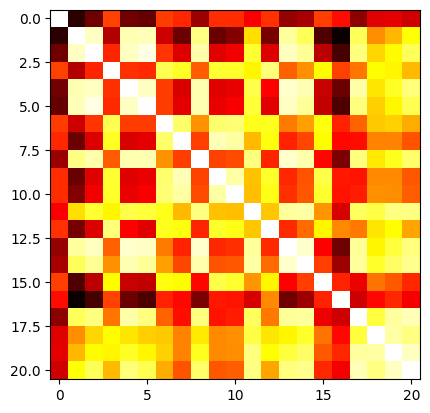

In [147]:
cos_similarity = (emds @ emds.transpose())
plt.imshow(cos_similarity, cmap='hot', interpolation='nearest')
plt.show()


In [150]:
cos_similarity[7,5]

0.39182287

In [97]:
context_embeddings[0].shape

torch.Size([768])

In [106]:
torch.dot(context_embeddings[1], context_embeddings[2])/(context_embeddings[1].norm()*context_embeddings[2].norm())

tensor(0.7359)

In [110]:
torch.dot(context_embeddings[1], context_embeddings[6])/(context_embeddings[1].norm()*context_embeddings[2].norm())

tensor(0.7102)

# Application example

In [75]:
df = pd.read_csv('../../data/eval_dataset.csv')

In [76]:
df['agent_first_msg'] = df['transcript'].map(lambda x: parse_transcript(x)[1]['agent_first_msg'])

In [78]:
refs = list(df['agent_first_msg'])
preds = list(df['best_sentence'])

In [79]:
results = bertscore.compute(predictions=preds, references=refs, lang="en", model_type="distilbert-base-uncased")


In [80]:
results

{'precision': [0.8157134056091309,
  0.7524710893630981,
  0.7802231311798096,
  0.8448470830917358,
  0.8061633110046387,
  0.683748722076416,
  0.7758551239967346,
  0.9291049242019653,
  0.6675654053688049,
  0.7445536255836487,
  0.7399338483810425,
  0.7711524963378906,
  0.6948302984237671,
  0.0,
  0.7463991045951843,
  0.715908408164978,
  0.7032756209373474,
  0.7548919916152954,
  0.6953153610229492,
  0.722528338432312,
  0.8002091646194458,
  0.7867988348007202,
  0.760385274887085,
  0.7243613004684448,
  0.730371356010437,
  0.6818893551826477,
  0.6844093799591064,
  0.7185503244400024,
  0.7615588307380676,
  0.6664412617683411,
  0.0,
  0.6789025068283081,
  0.6500875949859619,
  0.7217002511024475,
  0.6647307276725769,
  0.6542565822601318,
  0.7077241539955139,
  0.7533004283905029,
  0.6962152719497681,
  0.6942960023880005,
  0.7417731881141663,
  0.0,
  0.6962890028953552,
  0.722092866897583,
  0.715508222579956,
  0.64918452501297,
  0.5945636034011841,
  0.714